<a href="https://colab.research.google.com/github/NosenkoArtem/Categorical-Encoding/blob/master/seminar8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

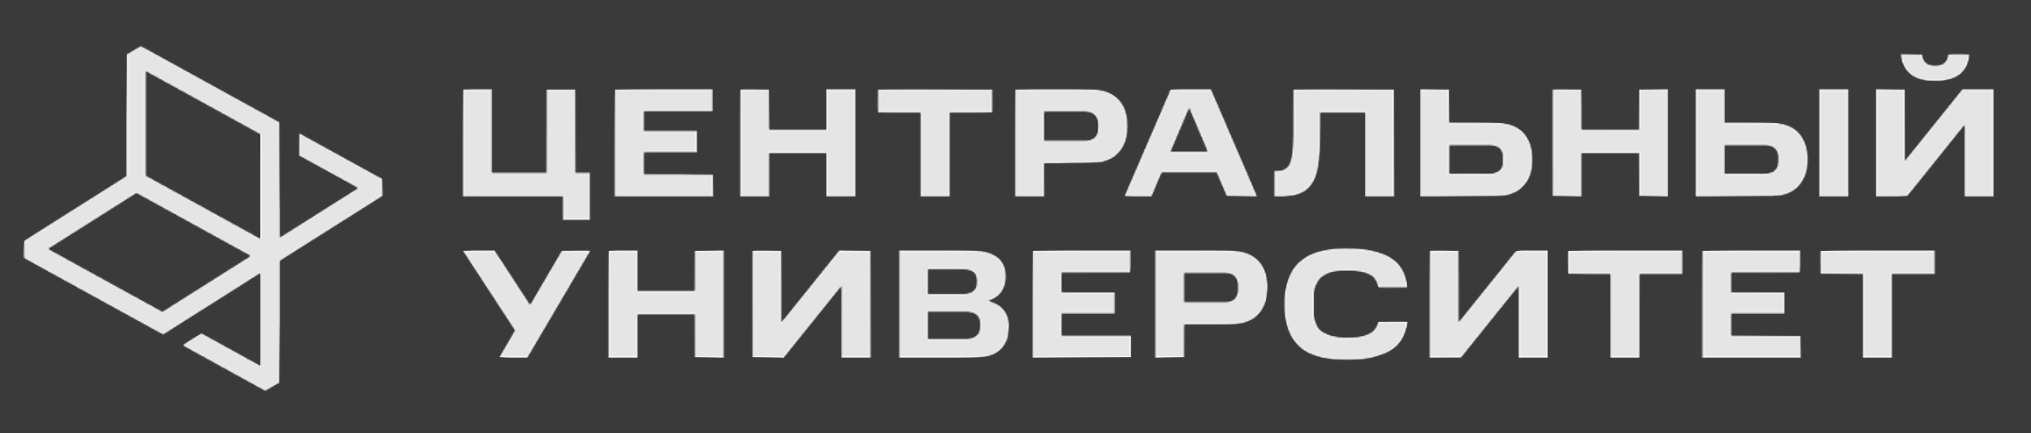

# Курс по машинному обучению

## Семинар 8. Ансамбли алгоритмов


Ансамблевые методы — это мета-алгоритмы, которые объединяют несколько машинных обучающихся моделей с целью улучшения эффективности прогнозирования. Они могут существенно улучшить производительность модели по сравнению с отдельными моделями.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from time import time
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

## 1.Формируем датасет

Датасет представляет собой случайную выборку 50к объектов из [Smoking and Drinking Dataset with body signal](https://www.kaggle.com/datasets/sooyoungher/smoking-drinking-dataset/data)

Датасет содержит данные о человеке (рост, вес, пол, возраст) и его биомаркеры (давление, холестерин, гемоглобин и т. д.)

Целевая переменная -- индикатор потребления алкоголя (0/1, бинарная классификация)

В качестве метрик будем использовать использовать Accuracy и F1-score, чтобы покрыть точность и полноту.
ROC-AUC не будем использовать в силу специфики наших моделей

In [ ]:
! gdown 1jA5b0ixzhmDydBcQKyn2R8M0Q3WkCBSM

Downloading...
From: https://drive.google.com/uc?id=1jA5b0ixzhmDydBcQKyn2R8M0Q3WkCBSM
To: /content/ensemble_seminar.parquet
100% 1.25M/1.25M [00:00<00:00, 46.7MB/s]


##### **<font color='DarkOrange'>Задание №1:</font>**
* Считайте файл в df
* Замените категориальные переменные sex, DRK_YN числовыми:
  * sex: Male = 1, Female = 0
  * DRK_YN: Y = 1, N = 0

Hint: может понадобиться функция [map](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html)

In [ ]:
df = pd.read_parquet("/content/ensemble_seminar.parquet")
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})
df['DRK_YN'] = df['DRK_YN'].map({'Y': 1, 'N': 0})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 889416 to 126220
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sex               50000 non-null  int64  
 1   age               50000 non-null  int64  
 2   height            50000 non-null  int64  
 3   weight            50000 non-null  int64  
 4   waistline         50000 non-null  float64
 5   sight_left        50000 non-null  float64
 6   sight_right       50000 non-null  float64
 7   hear_left         50000 non-null  float64
 8   hear_right        50000 non-null  float64
 9   SBP               50000 non-null  float64
 10  DBP               50000 non-null  float64
 11  BLDS              50000 non-null  float64
 12  tot_chole         50000 non-null  float64
 13  HDL_chole         50000 non-null  float64
 14  LDL_chole         50000 non-null  float64
 15  triglyceride      50000 non-null  float64
 16  hemoglobin        50000 non-null  float

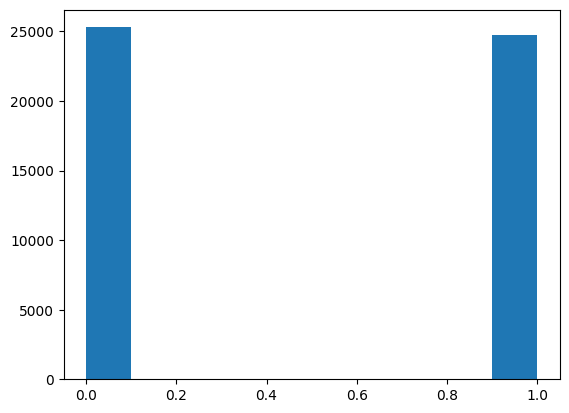

In [ ]:
# Распределение целевой переменной
plt.hist(df['DRK_YN'])
print()

In [ ]:
mm_scaler = MinMaxScaler()
df = pd.DataFrame(mm_scaler.fit_transform(df), columns=df.columns)

##### **<font color='DarkOrange'>Задание №2:</font>**
* Создайте матрицу корреляций, запишите её в переменную correlation_matrix

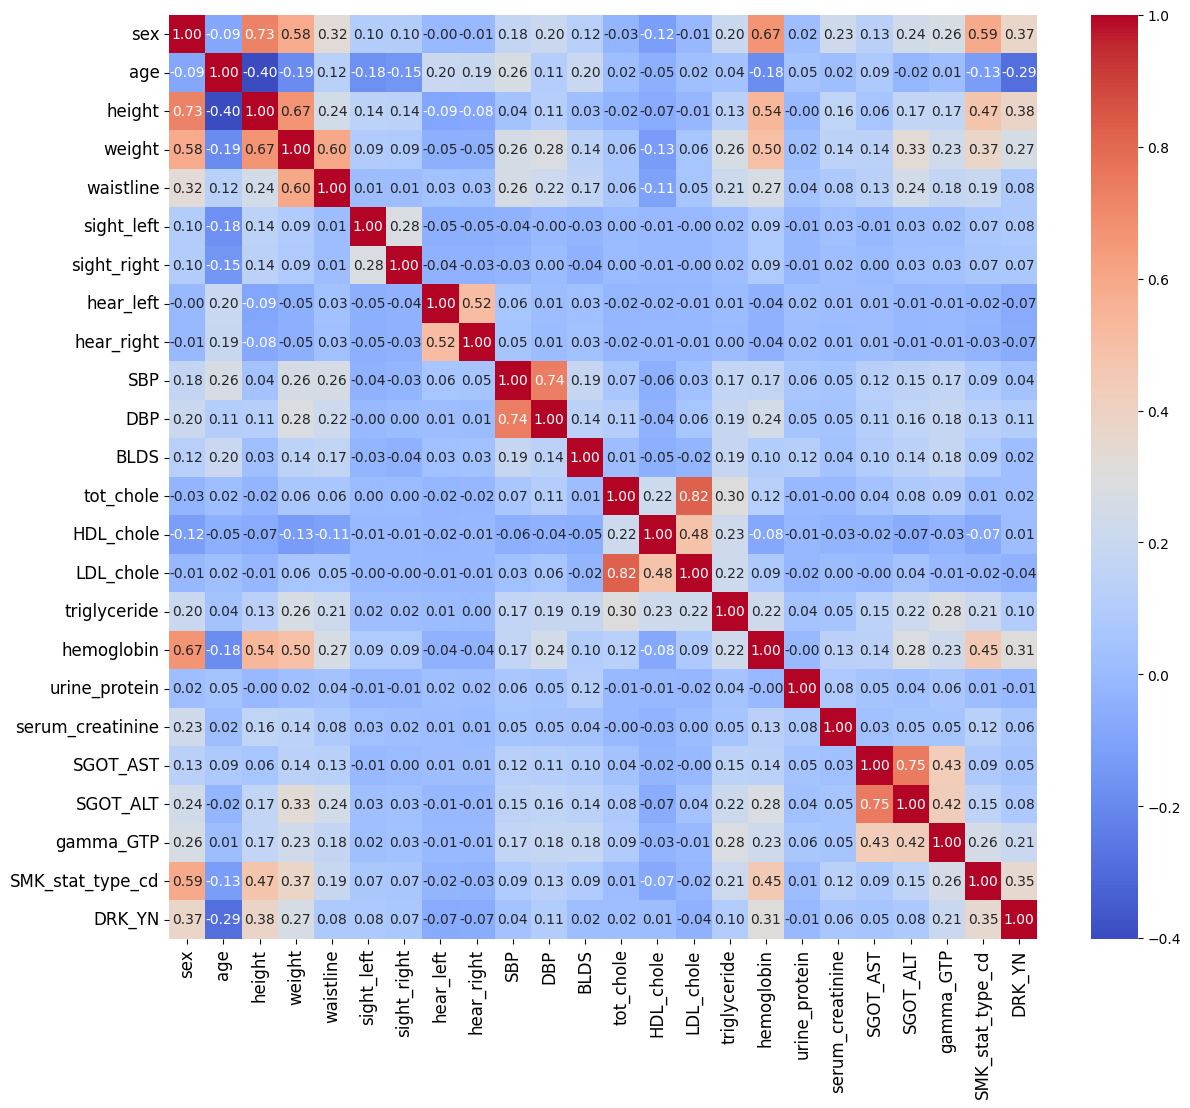

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(14,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
X, y = df.drop('DRK_YN', axis=1), df['DRK_YN']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

## 2.Бэггинг

\begin{align}
a(x) = \frac{1}{k}(b_1(x) + \dots + b_k(x))
    \end{align}

Процесс генерации подвыборок с помощью семплирования с возвращением называется бутстрепом (bootstrap), а модели $b_1(x), \ldots, b_k(x)$
 часто называют базовыми алгоритмами. Модель
 называется ансамблем этих моделей.

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
base_estimator = DecisionTreeClassifier(random_state=42)

bagging_classifier = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=50,  # количество деревьев в ансамбле
    random_state=42,
)

In [ ]:
%%time
bagging_classifier.fit(X_train, y_train)

CPU times: user 24.1 s, sys: 46.6 ms, total: 24.2 s
Wall time: 24.3 s


BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                  n_estimators=50, random_state=42)

In [ ]:
y_pred = bagging_classifier.predict(X_test)

In [ ]:
y_pred

array([1., 1., 0., ..., 1., 0., 0.])

In [ ]:
# Оцениваем качество
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.3f}')
print(f'F1 score: {f1:.3f}')

Accuracy: 0.724
F1 score: 0.717


In [ ]:
base_estimator = DecisionTreeClassifier(random_state=42)

In [ ]:
base_estimator.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
y_pred_base = base_estimator.predict(X_test)

In [ ]:
# Оцениваем качество
accuracy = accuracy_score(y_test, y_pred_base)
f1 = f1_score(y_test, y_pred_base)

print(f'Accuracy: {accuracy:.3f}')
print(f'F1 score: {f1:.3f}')

Accuracy: 0.640
F1 score: 0.638


#### 2.1 Посмотрим, как меняются метрики с ростом n_estimators

In [ ]:
accuracies = []
f1_scores = []
train_predict_times = []

In [ ]:
#!!!!!!!!!!!!!!
# Супер-долго работает, не запускать на семинаре
#!!!!!!!!!!!!!!!!

for n_estimators in tqdm(range(10, 151, 10)):
    base_estimator = DecisionTreeClassifier(random_state=42)

    bagging_classifier = BaggingClassifier(
        estimator=base_estimator,
        n_estimators=n_estimators,
        random_state=42
    )

    # Замеряем время начала обучения
    start_time = time()

    # Обучаем ансамбль
    bagging_classifier.fit(X_train, y_train)

    # Строим прогнозы на тесте
    y_pred = bagging_classifier.predict(X_test)

    # Замеряем время окончания обучения
    end_time = time()

    # Сохраняем метрики и время
    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    train_predict_times.append(end_time - start_time)

  0%|          | 0/15 [00:00<?, ?it/s]

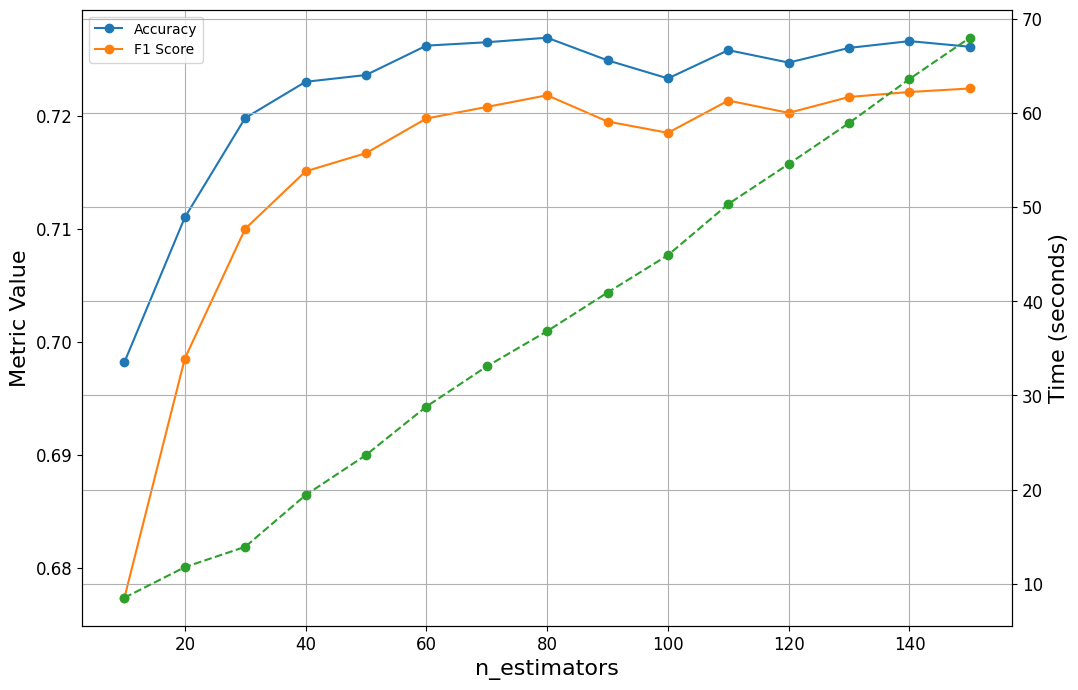

In [ ]:
# Строим график
n_estimators_values = list(range(10, 151, 10))

plt.figure(figsize=(12, 8))

ax1 = plt.gca()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax1.plot(n_estimators_values, accuracies, label='Accuracy', marker='o', color='tab:blue')
ax1.plot(n_estimators_values, f1_scores, label='F1 Score', marker='o', color='tab:orange')
ax1.set_xlabel('n_estimators', fontsize=16)
ax1.set_ylabel('Metric Value', fontsize=16)
ax1.legend()
ax1.tick_params(axis='y')
plt.grid(axis='x')

ax2 = ax1.twinx()
plt.yticks(fontsize=12)
ax2.plot(n_estimators_values, train_predict_times, label='Iteration Time (seconds)',
         linestyle='dashed', marker='o', color='tab:green')
ax2.set_ylabel('Time (seconds)', fontsize=16)
ax2.tick_params(axis='y')

plt.grid()
plt.show()

##### Использование warm_start

In [ ]:
accuracies = []
f1_scores = []
train_predict_times = []
results = []
base_estimator = DecisionTreeClassifier(random_state=42)

bagging_classifier = BaggingClassifier(
        estimator=base_estimator,
        n_estimators=10,
        warm_start=True, # Переиспользуем уже обученные деревья
        random_state=42
    )

for i in tqdm(range(15)):

    start_time = time()
    bagging_classifier.fit(X_train, y_train)
    y_pred = bagging_classifier.predict(X_test)
    end_time = time()

    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    train_predict_times.append(end_time - start_time)

    # Добавляем ещё 10 деревьев
    bagging_classifier.n_estimators += 10

  0%|          | 0/15 [00:00<?, ?it/s]

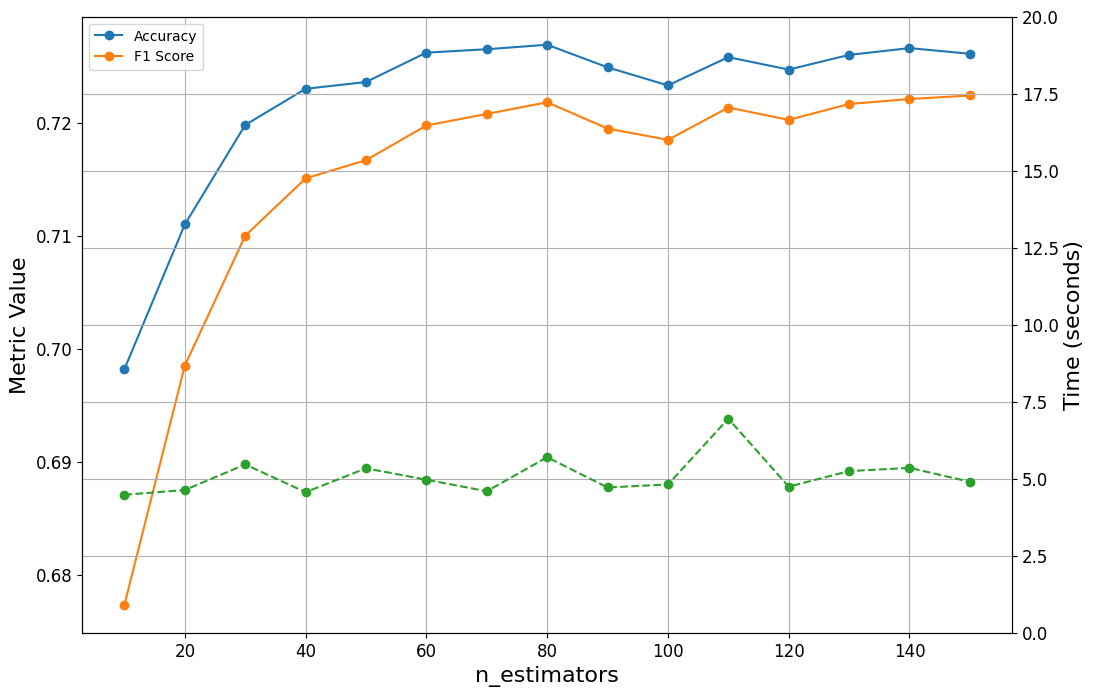

In [ ]:
# Строим график
n_estimators_values = list(range(10, 151, 10))

plt.figure(figsize=(12, 8))

ax1 = plt.gca()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax1.plot(n_estimators_values, accuracies, label='Accuracy', marker='o', color='tab:blue')
ax1.plot(n_estimators_values, f1_scores, label='F1 Score', marker='o', color='tab:orange')
ax1.set_xlabel('n_estimators', fontsize=16)
ax1.set_ylabel('Metric Value', fontsize=16)
ax1.legend()
ax1.tick_params(axis='y')
plt.grid(axis='x')

ax2 = ax1.twinx()
plt.yticks(fontsize=12)
ax2.set_ylim(top=20)
ax2.plot(n_estimators_values, train_predict_times, label='Iteration Time (seconds)',
         linestyle='dashed', marker='o', color='tab:green')
ax2.set_ylabel('Time (seconds)', fontsize=16)
ax2.tick_params(axis='y')

plt.grid(True)
plt.show()

#### 2.2 Посмотрим, как меняются метрики с ростом max_depth

#####**<font color='DarkOrange'>Задание №3:</font>**
Написать цикл по перебору max_depth для базовой модели (решающего дерева). На каждой итерации надо:
* Инициализировать базовую модель и бэггинг
* Обучить ансамбль
* Записать прогноз на тестовой выборке
* Добавить в списки метрик значения accuracy и f1-score на этой итерации

In [ ]:
accuracies = []
f1_scores = []
train_predict_times = []
results = []

In [ ]:
#!!!!!!!!!!!!!!
# Работает около 5-10 минут
#!!!!!!!!!!!!!!!!

for depth in tqdm(range(3, 20)):

    base_estimator = DecisionTreeClassifier(max_depth=depth, random_state=42)

    bagging_classifier = BaggingClassifier(
        estimator=base_estimator,
        n_estimators=70,
        random_state=42
    )

    start_time = time()
    bagging_classifier.fit(X_train, y_train)
    y_pred = bagging_classifier.predict(X_test)
    end_time = time()

    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    train_predict_times.append(end_time - start_time)

  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
df.shape

(50000, 24)

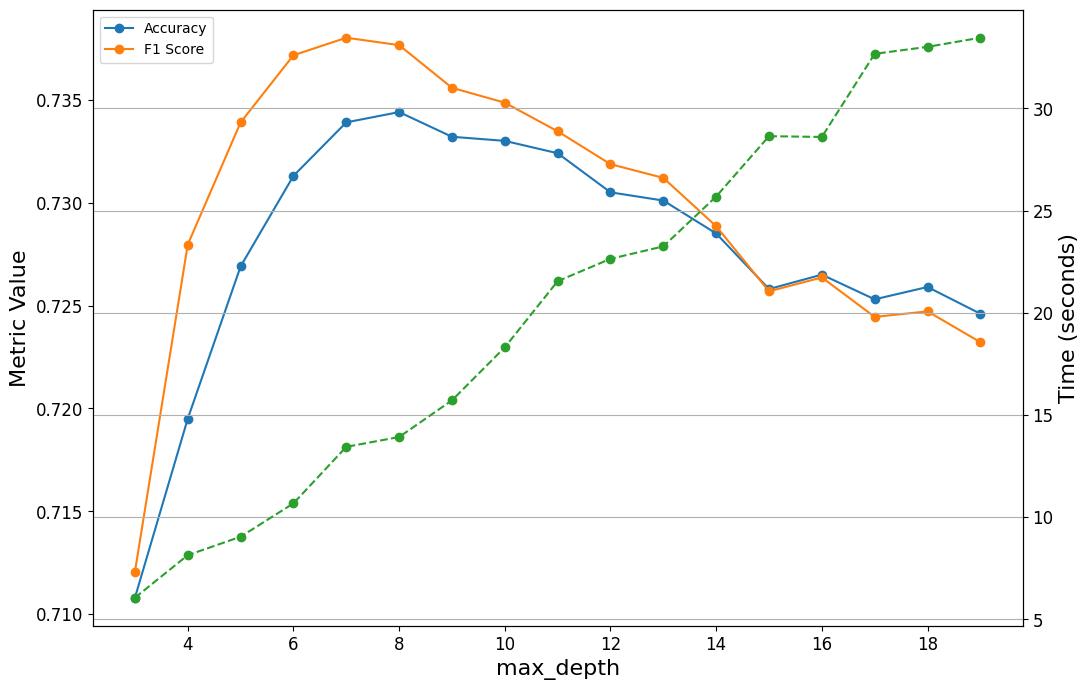

In [ ]:
# Строим график
max_depth_values = list(range(3, 20))

plt.figure(figsize=(12, 8))

ax1 = plt.gca()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax1.plot(max_depth_values, accuracies, label='Accuracy', marker='o', color='tab:blue')
ax1.plot(max_depth_values, f1_scores, label='F1 Score', marker='o', color='tab:orange')
ax1.set_xlabel('max_depth', fontsize=16)
ax1.set_ylabel('Metric Value', fontsize=16)
ax1.legend(loc='upper left')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
plt.yticks(fontsize=12)
ax2.plot(max_depth_values, train_predict_times, label='Iteration Time (seconds)',
         linestyle='dashed', marker='o', color='tab:green')
ax2.set_ylabel('Time (seconds)', fontsize=16)
ax2.tick_params(axis='y')

plt.grid(True)
plt.show()

<font color='DarkOrange'>**Вопрос №1:**</font> Переобучается ли модель с ростом max_depth? Как сильно?

#### 2.3 Зависимость метрик от max_features

In [ ]:
df = pd.read_parquet('ensemble_seminar.parquet')
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})
df['DRK_YN'] = df['DRK_YN'].map({'Y': 1, 'N': 0})

X, y = df.drop('DRK_YN', axis=1), df['DRK_YN']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

mm_scaler = MinMaxScaler()
df = pd.DataFrame(mm_scaler.fit_transform(df), columns=df.columns)

In [ ]:
#!!!!!!!!!!!!!!
# Работает около 3-5 минут
#!!!!!!!!!!!!!!!!

accuracies = []
f1_scores = []
train_predict_times = []

for features_ratio in tqdm(range(2, len(X_train.columns), 2)):
    # создаем базовый классификатор
    base_estimator = DecisionTreeClassifier(random_state=42)

    # создаем бэггинг из базовых классификаторов
    bagging_classifier = BaggingClassifier(
        estimator=base_estimator,
        n_estimators=50,
        max_features=features_ratio,
        random_state=42
    )
    # замеряем время
    start_time = time()
    # обучаем модель, делаем предсказание на отложенной выборке
    bagging_classifier.fit(X_train, y_train)
    y_pred = bagging_classifier.predict(X_test)
    end_time = time()

    # сохраняем метрики
    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    train_predict_times.append(end_time - start_time)

  0%|          | 0/11 [00:00<?, ?it/s]

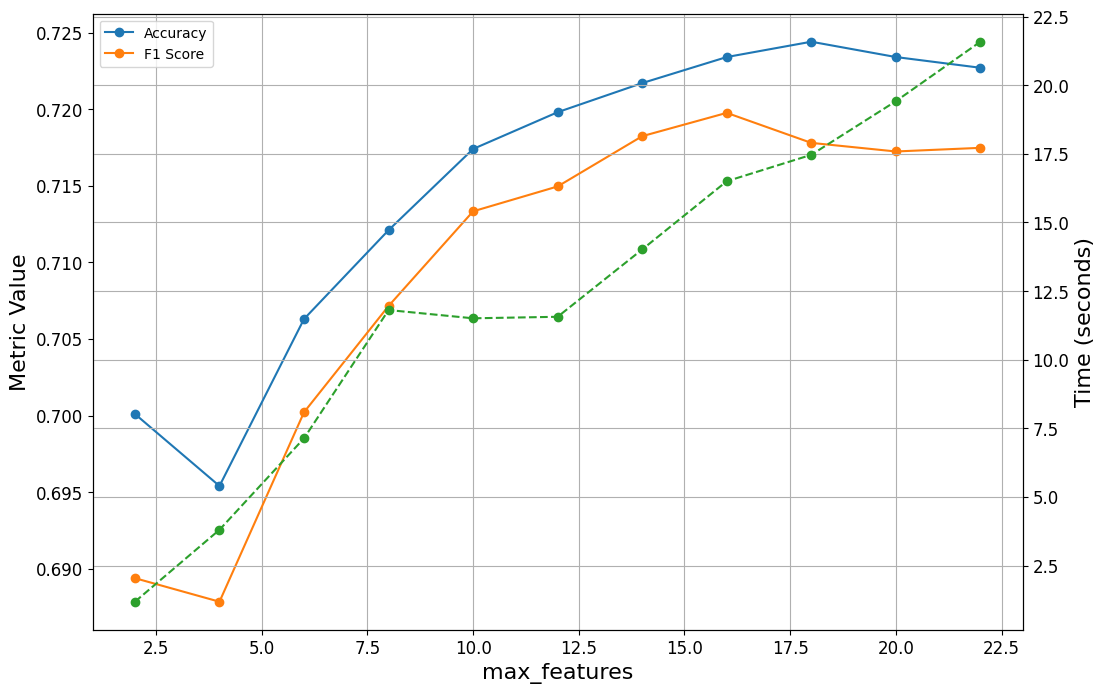

In [ ]:
# Строим график
max_features_values = range(2, len(X_train.columns), 2)

plt.figure(figsize=(12, 8))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax1 = plt.gca()
ax1.plot(max_features_values, accuracies, label='Accuracy', marker='o', color='tab:blue')
ax1.plot(max_features_values, f1_scores, label='F1 Score', marker='o', color='tab:orange')
ax1.set_xlabel('max_features', fontsize=16)
ax1.set_ylabel('Metric Value', fontsize=16)
ax1.legend()
ax1.tick_params(axis='y')
plt.grid(axis='x')

ax2 = ax1.twinx()
plt.yticks(fontsize=12)
ax2.plot(max_features_values, train_predict_times, label='Iteration Time (seconds)',
         linestyle='dashed', marker='o', color='tab:green')
ax2.set_ylabel('Time (seconds)', fontsize=16)
ax2.tick_params(axis='y')

plt.grid(True)
plt.show()

##### <font color='DarkOrange'>**Вопрос №2:**</font> Почему в бэггинге используются деревья?

#### 2.4 Бэггинг над логистическими регрессиями

In [ ]:
accuracies = []
f1_scores = []
train_predict_times = []

base_estimator = LogisticRegression(max_iter=200, random_state=42)

bagging_classifier = BaggingClassifier(
        estimator=base_estimator,
        n_estimators=1,
        warm_start=True, # Переиспользуем уже обученные логреги
        random_state=42
    )

In [ ]:
for i in tqdm(range(15)):

    start_time = time()
    bagging_classifier.fit(X_train, y_train)
    y_pred = bagging_classifier.predict(X_test)
    end_time = time()

    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    train_predict_times.append(end_time - start_time)

    # Добавляем ещё 1 логрег
    bagging_classifier.n_estimators += 1

  0%|          | 0/15 [00:00<?, ?it/s]

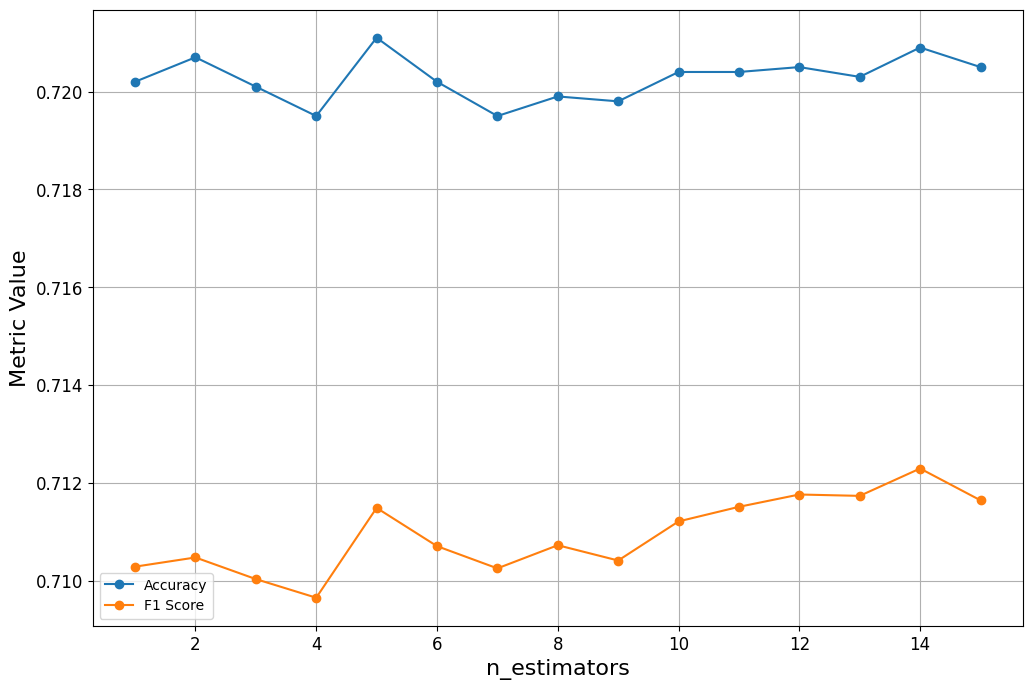

In [ ]:
# Строим график
n_estimator_values = range(1, 16)

plt.figure(figsize=(12, 8))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(n_estimator_values, accuracies, label='Accuracy', marker='o', color='tab:blue')
plt.plot(n_estimator_values, f1_scores, label='F1 Score', marker='o', color='tab:orange')
plt.xlabel('n_estimators', fontsize=16)
plt.ylabel('Metric Value', fontsize=16)
plt.legend()
plt.tick_params(axis='y')

plt.grid(True)
plt.show()

##### <font color='DarkOrange'>**Вопрос №3:**</font> Почему качество не расчет при увеличении числа алгоритмов?

###### Пробуем повысить вариативность моделей

In [ ]:
accuracies = []
f1_scores = []
train_predict_times = []

base_estimator = LogisticRegression(max_iter=100, random_state=42)

bagging_classifier = BaggingClassifier(
        estimator=base_estimator,
        n_estimators=1,
        max_samples=0.1, # Делаем повыборки размером 10% от исходного train
        warm_start=True, # Переиспользуем уже обученные логреги
        random_state=42
    )

In [ ]:
for i in tqdm(range(15)):

    start_time = time()
    bagging_classifier.fit(X_train, y_train)
    y_pred = bagging_classifier.predict(X_test)
    end_time = time()

    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    train_predict_times.append(end_time - start_time)

    # Добавляем ещё 1 логрег
    bagging_classifier.n_estimators += 1

  0%|          | 0/15 [00:00<?, ?it/s]

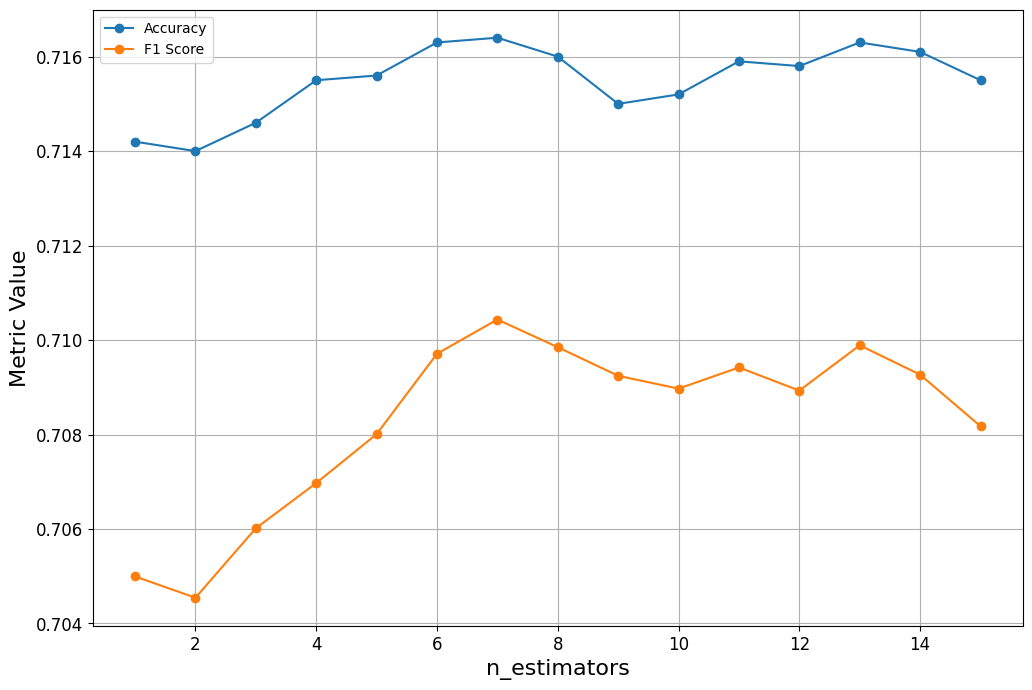

In [ ]:
# Строим график
n_estimator_values = range(1, 16)

plt.figure(figsize=(12, 8))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(n_estimator_values, accuracies, label='Accuracy', marker='o', color='tab:blue')
plt.plot(n_estimator_values, f1_scores, label='F1 Score', marker='o', color='tab:orange')
plt.xlabel('n_estimators', fontsize=16)
plt.ylabel('Metric Value', fontsize=16)
plt.legend()
plt.tick_params(axis='y')

plt.grid(True)
plt.show()

#### 2.5 Бэггинг над kNN

In [ ]:
accuracies = []
f1_scores = []
train_predict_times = []

base_estimator = KNeighborsClassifier(n_neighbors=5)

bagging_classifier = BaggingClassifier(
        estimator=base_estimator,
        n_estimators=1,
        warm_start=True, # Переиспользуем уже обученные kNN
        random_state=42
    )

In [ ]:
#!!!!!!!!!!!!!!
# Работает около 3-5 минут
#!!!!!!!!!!!!!!!!

for i in tqdm(range(15)):

    start_time = time()
    bagging_classifier.fit(X_train, y_train)
    y_pred = bagging_classifier.predict(X_test)
    end_time = time()

    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    train_predict_times.append(end_time - start_time)

    # Добавляем ещё 1 kNN
    bagging_classifier.n_estimators += 1

  0%|          | 0/15 [00:00<?, ?it/s]

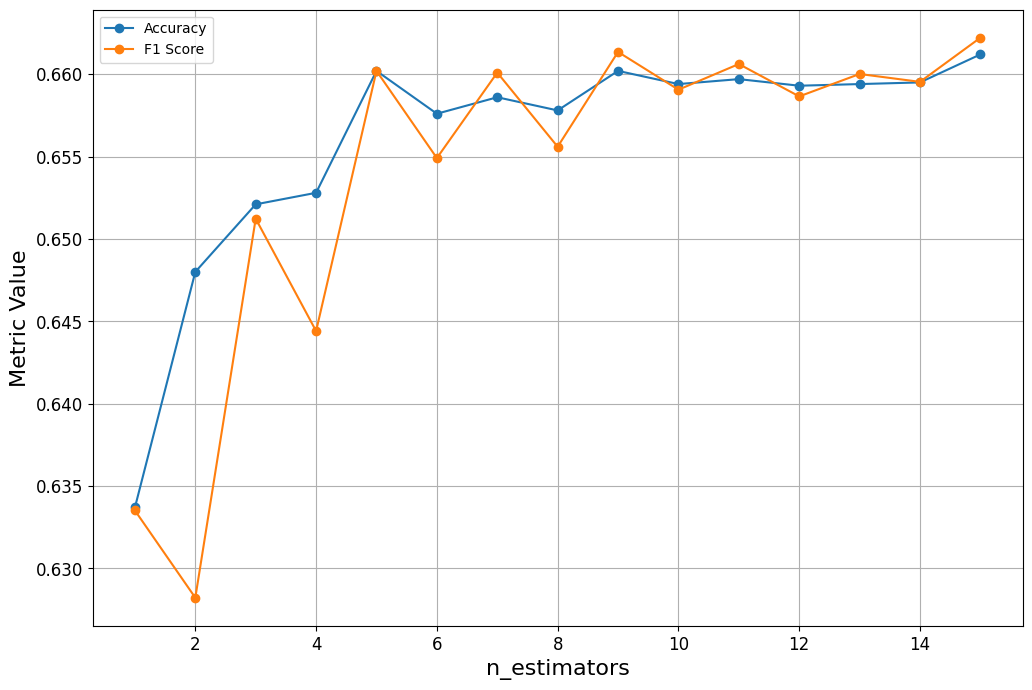

In [ ]:
# Строим график
n_estimator_values = range(1, 16)

plt.figure(figsize=(12, 8))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(n_estimator_values, accuracies, label='Accuracy', marker='o', color='tab:blue')
plt.plot(n_estimator_values, f1_scores, label='F1 Score', marker='o', color='tab:orange')
plt.xlabel('n_estimators', fontsize=16)
plt.ylabel('Metric Value', fontsize=16)
plt.legend()
plt.tick_params(axis='y')

plt.grid(True)
plt.show()

## 3.Стекинг и блендинг

Стекинг — это ансамбль алгоритмов, в котором базовые модели обучаются на данных, а затем их предсказания используются как входные данные для "мета-модели", которая стремится улучшить окончательное предсказание. Этот метод позволяет комбинировать сильные стороны различных моделей и может привести к более высокой обобщающей способности в сравнении с отдельными моделями

Блендинг — простейшая реализация стекинга, на котором обучающую выборку разделяют на 2 части: на одной части обучают базовые алгоритмы, а на другой мета-алгоритм

<img src='https://alexanderdyakonov.files.wordpress.com/2017/03/stacking.png' width=800>

Схема блендинга







### 3.1 Базовые модели
Для начала давайте обучим базовые модели, чтобы было, с чем сравнивать

##### **<font color='DarkOrange'>Задание №4:</font>**
* Создайте 3 модели: логистическую регрессию, kNN, решающее дерево
* Зафиксируйте гиперпараметры: для kNN n_neighbors=9, для остальных моделей random_state=42
* Обучите модели на train выборке
* Запишите прогноз этих моделей по test выборке

In [ ]:
res = {
       'model' : [],
       'accuracy' :[],
       'f1':[]
       }

In [ ]:
lr_model = LogisticRegression(random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=9)
dt_model = DecisionTreeClassifier(random_state=42)

In [ ]:
%%time
lr_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)

CPU times: user 1.75 s, sys: 398 ms, total: 2.15 s
Wall time: 3.24 s


DecisionTreeClassifier(random_state=42)

In [ ]:
%%time
lr_preds = lr_model.predict(X_test)
knn_preds = knn_model.predict(X_test)
dt_preds = dt_model.predict(X_test)

CPU times: user 4.89 s, sys: 110 ms, total: 5 s
Wall time: 6.77 s


In [ ]:
lr_accuracy = accuracy_score(y_test, lr_preds)
knn_accuracy = accuracy_score(y_test, knn_preds)
dt_accuracy = accuracy_score(y_test, dt_preds)

lr_f1 = f1_score(y_test, lr_preds)
knn_f1 = f1_score(y_test, knn_preds)
dt_f1 = f1_score(y_test, dt_preds)

In [ ]:
# lr_accuracy = accuracy_score(y_test, lr_preds)
# knn_accuracy = accuracy_score(y_test, knn_preds)
# dt_accuracy = accuracy_score(y_test, dt_preds)

# lr_f1 = f1_score(y_test, lr_preds)
# knn_f1 = f1_score(y_test, knn_preds)
# dt_f1 = f1_score(y_test, dt_preds)

res['model'].append('lr')
res['accuracy'].append(lr_accuracy)
res['f1'].append(lr_f1)

In [ ]:
print(f'Accuracy of LR: {lr_accuracy:.3f}')
print(f'Accuracy of KNN: {knn_accuracy:.3f}')
print(f'Accuracy of Decision Tree: {dt_accuracy:.3f}')


print(f'\nF1 score of LR: {lr_f1:.3f}')
print(f'F1 score of KNN: {knn_f1:.3f}')
print(f'F1 score of Decision Tree: {dt_f1:.3f}')

Accuracy of LR: 0.714
Accuracy of KNN: 0.675
Accuracy of Decision Tree: 0.641

F1 score of LR: 0.706
F1 score of KNN: 0.678
F1 score of Decision Tree: 0.639


#### 3.2 Согласованность предсказаний

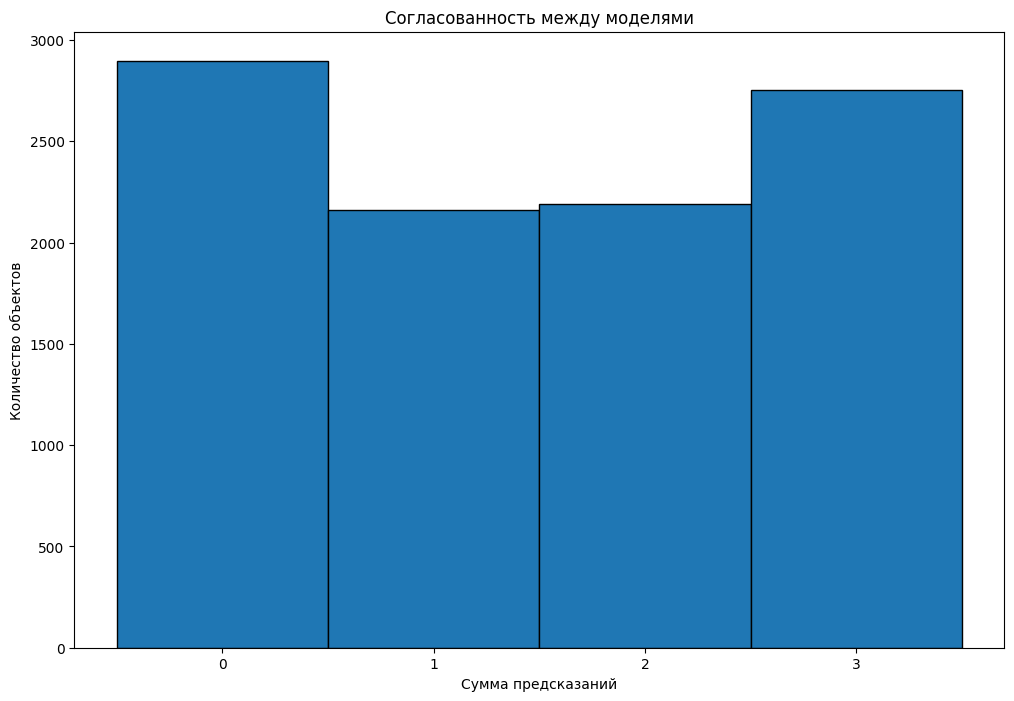

In [ ]:
agreement = [sum(x) for x in zip(lr_preds, knn_preds, dt_preds)]

# Построение гистограммы
plt.figure(figsize=(12, 8))
plt.hist(agreement, bins=[0, 1, 2, 3, 4], edgecolor='black')
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=['0', '1', '2', '3'])
plt.title('Согласованность между моделями')
plt.xlabel('Сумма предсказаний')
plt.ylabel('Количество объектов')
plt.show()

#### Комитет большинства

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
voting_clf = VotingClassifier(estimators=[
        ('LR', lr_model), ('kNN', knn_model), ('dt', dt_model)], voting='hard')

voting_clf = voting_clf.fit(X_train, y_train)
voting_preds = voting_clf.predict(X_test)

In [ ]:
voting_accuracy = accuracy_score(y_test, voting_preds)
voting_f1 = f1_score(y_test, voting_preds)

res['model'].append('voting')
res['accuracy'].append(voting_accuracy)
res['f1'].append(voting_f1)

print(f'Accuracy of voting: {voting_accuracy:.3f}')
print(f'F1 score of voting: {voting_f1:.3f}')

Accuracy of voting: 0.707
F1 score of voting: 0.704


### 3.2 Блендинг

##### **<font color='DarkOrange'>Задание №5:</font>**
* Разбейте обучающую выборку на base_train для базовых моделей и meta_train для мета-модели в пропорции 80/20
* Заполните пропуски в функциях .fit()

In [ ]:
# Разбиваем обучающий датасет
X_base_train, X_meta_train, \
y_base_train, y_meta_train = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# Базовые модели
lr_model = LogisticRegression(random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=9)
dt_model = DecisionTreeClassifier(random_state=42)

In [ ]:
%%time
lr_model.fit(X_base_train, y_base_train)
knn_model.fit(X_base_train, y_base_train)
dt_model.fit(X_base_train, y_base_train)

CPU times: user 1.06 s, sys: 355 ms, total: 1.41 s
Wall time: 956 ms


DecisionTreeClassifier(random_state=42)

In [ ]:
%%time
lr_preds = lr_model.predict(X_meta_train)
knn_preds = knn_model.predict(X_meta_train)
dt_preds = dt_model.predict(X_meta_train)

CPU times: user 2.97 s, sys: 96.7 ms, total: 3.06 s
Wall time: 5.06 s


In [ ]:
X_meta_train = np.column_stack((lr_preds, knn_preds, dt_preds))

In [ ]:
%%time
meta_model = LogisticRegression(random_state=42)
meta_model.fit(X_meta_train, y_meta_train)

CPU times: user 12.8 ms, sys: 14.8 ms, total: 27.5 ms
Wall time: 30.8 ms


LogisticRegression(random_state=42)

In [ ]:
%%time
lr_preds = lr_model.predict(X_test)
knn_preds = knn_model.predict(X_test)
dt_preds = dt_model.predict(X_test)
X_meta_test = np.column_stack((lr_preds, knn_preds, dt_preds))

CPU times: user 2.58 s, sys: 149 ms, total: 2.73 s
Wall time: 2.57 s


In [ ]:
blending_preds = meta_model.predict(X_meta_test)

In [ ]:
# Оценка качества
blending_accuracy = accuracy_score(y_test, blending_preds)
blending_f1 = f1_score(y_test, blending_preds)

res['model'].append('blending')
res['accuracy'].append(blending_accuracy)
res['f1'].append(blending_f1)

print(f'Accuracy of Blending (LR): {blending_accuracy:.3f}')
print(f'F1 score of Blending (LR): {blending_f1:.3f}')

Accuracy of Blending (LR): 0.709
F1 score of Blending (LR): 0.690


### 3.3 Стекинг

<img src='https://alexanderdyakonov.files.wordpress.com/2017/03/stacking-2b.png' width=800>

Схема стекинга

In [ ]:
from sklearn.model_selection import cross_val_predict

In [ ]:
lr_model = LogisticRegression(random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=9)
dt_model = DecisionTreeClassifier(random_state=42)

lr_train_preds = cross_val_predict(lr_model, X_train, y_train)
knn_train_preds = cross_val_predict(knn_model, X_train, y_train)
dt_train_preds = cross_val_predict(dt_model, X_train, y_train)

<img src='https://drive.google.com/uc?export=view&id=1joyFJYLTCnyBpD2wfcDnT-wnWfbSmY1-' width=600>

In [ ]:
X_meta_train = np.column_stack((lr_train_preds, knn_train_preds, dt_train_preds))

In [ ]:
lr_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)

lr_test_preds = lr_model.predict(X_test)
knn_test_preds = knn_model.predict(X_test)
dt_test_preds = dt_model.predict(X_test)

In [ ]:
X_meta_test = np.column_stack((lr_test_preds, knn_test_preds, dt_test_preds))

In [ ]:
%%time
meta_model = LogisticRegression()
meta_model.fit(X_meta_train, y_train)

CPU times: user 46.6 ms, sys: 28.6 ms, total: 75.2 ms
Wall time: 43.5 ms


LogisticRegression()

In [ ]:
stacking_preds = meta_model.predict(X_meta_test)

In [ ]:
# Оценка качества
stacking_accuracy = accuracy_score(y_test, stacking_preds)
stacking_f1 = f1_score(y_test, stacking_preds)

print(f'Accuracy of Stacked Model (LR): {stacking_accuracy:.3f}')
print(f'F1 score of Stacked Model (LR): {stacking_f1:.3f}')

Accuracy of Stacked Model (LR): 0.714
F1 score of Stacked Model (LR): 0.705


<font color='DarkOrange'> **Вопрос №4:**</font> Как можно повысить качество модели?

#### Стекинг из коробки

In [ ]:
from sklearn.ensemble import StackingClassifier

lr_model = LogisticRegression(random_state=42)
knn_model = KNeighborsClassifier()
dt_model = DecisionTreeClassifier(random_state=42)

estimators = [
    ('LR', lr_model), ('kNN', knn_model), ('dt', dt_model)]

clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression())

clf.fit(X_train, y_train)

stacking_preds = clf.predict(X_test)

In [ ]:
# Оценка качества
stacking_accuracy = accuracy_score(y_test, stacking_preds)
stacking_f1 = f1_score(y_test, stacking_preds)

res['model'].append('stacking')
res['accuracy'].append(stacking_accuracy)
res['f1'].append(stacking_f1)

print(f'Accuracy of Stacked Model (LR): {stacking_accuracy:.3f}')
print(f'F1 score of Stacked Model (LR): {stacking_f1:.3f}')

Accuracy of Stacked Model (LR): 0.717
F1 score of Stacked Model (LR): 0.710


In [ ]:
df_res = pd.DataFrame(res)
df_res

,model,accuracy,f1
0,lr,0.7136,0.705289
1,voting,0.7063,0.703961
2,blending,0.7091,0.690037
3,stacking,0.7170,0.710219


## 4. Итог

### 4.1 Бэггинг
Преимущества:
* Уменьшает переобучение, сохраняя высокую сложность базовых моделей.
* Улучшает стабильность и точность предсказаний, особенно в случае с высокой дисперсией базовых моделей.

Недостатки:
* Не всегда удается улучшить производительность, если базовые модели уже достаточно хороши или смещены.

Важно подбирать гиперпараметры, т. к. это позволяет одновременно сократить время на обучение и вырасти в качестве

### 4.2 Блендинг
Преимущества:
* Прост в реализации и требует меньше времени на настройку по сравнению со стекингом.
* Позволяет комбинировать различные модели, улучшая обобщающую способность.

Недостатки:
* Может не давать значительного улучшения, если базовые модели сильно скоррелированы.
* Сокращаем обучающий датасет, есть риск переобучиться



### 4.3 Стекинг
Преимущества:
* Позволяет комбинировать различные модели, улучшая обобщающую способность.
* Используем весь обучающий датасет

Недостатки:
* Сложнее в реализации и настройке

## Ссылки

1.   [Соревнование на kaggle](https://www.kaggle.com/datasets/sooyoungher/smoking-drinking-dataset/data)
2.   [Статья из ML Handbook](https://education.yandex.ru/handbook/ml/article/ansambli-v-mashinnom-obuchenii)
3.   [Models compositions example (Kaggle)](https://www.kaggle.com/code/alexryzhkov/models-compositions-example#Composition-1---select-best/)
4.   [LightAutoML library](https://lightautoml.readthedocs.io/en/latest/pages/Tutorials.html)

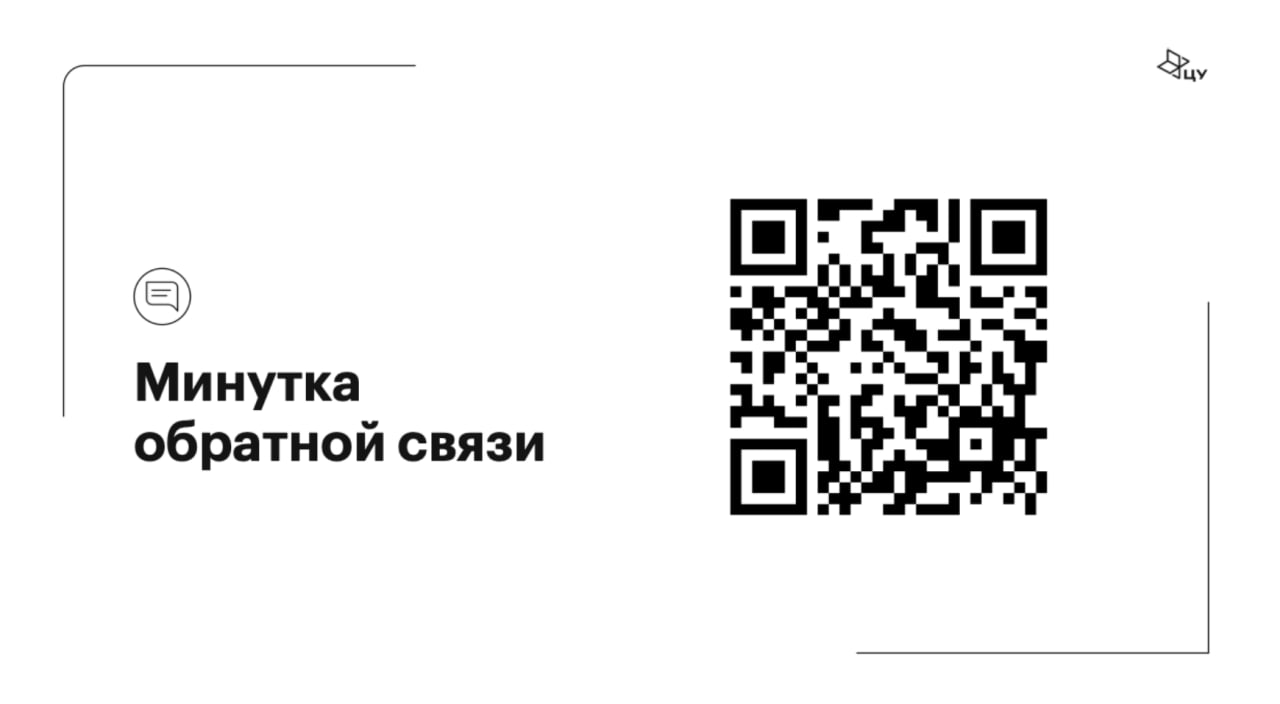